*** file: data/ChaLearn/crop_images/_01AyUz9J9I.002.mp4-00081.jpg ***
Detection 0: Left: 23 Top: 24 Right: 91 Bottom: 93


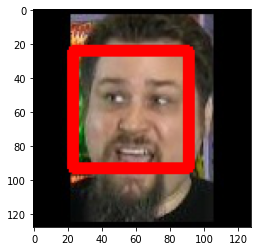

(128,)
[-7.99672678e-02  1.33297946e-02  3.28956656e-02 -4.51918133e-02
 -1.88345596e-01  6.36512712e-02  5.00196517e-02 -1.02002360e-01
  8.74009058e-02 -1.13706896e-02  1.25094742e-01 -4.10677791e-02
 -2.77613193e-01 -2.87927128e-02 -4.94817458e-02  1.43383726e-01
 -2.26565059e-02 -1.49531186e-01 -8.00334513e-02 -2.66562235e-02
 -4.54064235e-02  4.96037565e-02 -1.60883460e-02  6.97854012e-02
 -2.06953324e-02 -3.23400110e-01 -8.39241743e-02 -6.34722561e-02
  1.46043962e-02 -1.01239942e-01 -1.00105390e-01  2.99960580e-02
 -1.25896499e-01 -8.76845419e-02  4.56383154e-02  9.93664712e-02
 -1.26936674e-01 -1.32396787e-01  1.75604999e-01  8.80599022e-02
 -1.23315677e-01  1.65647827e-04  8.03009719e-02  3.42029721e-01
  1.30750924e-01  3.57958414e-02  7.61353225e-02 -1.63914002e-02
  1.35339200e-01 -3.13775063e-01  1.22889929e-01  6.58057854e-02
  1.65509433e-01  5.24192378e-02  9.75838155e-02 -1.27974108e-01
  4.87914681e-03  1.03662744e-01 -1.99148580e-01  1.14090189e-01
  8.57412592e-02  

In [1]:
import cv2
import matplotlib.pyplot as plt
import face_recognition


files = ['data/ChaLearn/crop_images/_01AyUz9J9I.002.mp4-00081.jpg']
for f in files:
    print("*** file: {} ***".format(f))
    img = face_recognition.load_image_file(f)
    face_locations = face_recognition.face_locations(img, model="cnn")
    codes = face_recognition.face_encodings(img, known_face_locations=face_locations, model="large")

    if len(codes) == 0:
        print("no face")
        plt.figure(figsize = (4,4))
        plt.imshow(img)
        plt.show()
    else:
        for i, code in enumerate(codes):
            print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
                i, face_locations[i][3], face_locations[i][0], face_locations[i][1], face_locations[i][2]))
            disp = img.copy()
            cv2.rectangle(disp, (face_locations[i][3], face_locations[i][0]), (face_locations[i][1], face_locations[i][2]), (255, 0, 0), 6)
            plt.figure(figsize=(4,4))
            plt.imshow(disp)
            plt.show()
            print(codes[i].shape)
            print(codes[i])

In [2]:
from params import RANDOM_SEED, LocationConfig, CreateDataConfig
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import fnmatch
import pickle
import cv2
import os

def create_new_data_directories():
    Path(LocationConfig.data).mkdir(exist_ok=True, parents=True)
    Path(LocationConfig.data + 'train').mkdir(exist_ok=True, parents=True)
    Path(LocationConfig.data + 'test').mkdir(exist_ok=True, parents=True)
    Path(LocationConfig.crop_images).mkdir(exist_ok=True, parents=True)
    
create_new_data_directories()

In [22]:
def get_short_video_name(videoNames):
    ShortVideoName = []
    for videoName in videoNames.values:
        ShortVideoName.append(videoName.split('.')[0])
    return ShortVideoName

def create_mean_video_name_df(df):
    cols = ['ValueExtraversion','ValueAgreeableness','ValueConscientiousness','ValueNeurotisicm','ValueOpenness','ShortVideoName']
    grouped_df = df[cols].groupby('ShortVideoName')
    mean_df = grouped_df.mean()
    mean_df = mean_df.reset_index()
    return mean_df



def create_dataset_ChaLearn(images_path):
    df = pd.read_csv(LocationConfig.labels + 'bigfive_labels.csv')

    df['ShortVideoName'] = get_short_video_name(df['VideoName'])

    mean_df = create_mean_video_name_df(df)
    mean_df.to_csv(LocationConfig.labels + 'bigfive_labels_mean.csv')
    df = mean_df.set_index('ShortVideoName')
    all_x = np.array(df.index)
    X_train, X_test = train_test_split(
        all_x, 
        test_size=CreateDataConfig.test_size_ratio,
        random_state=0
    )

    images_dict_train = {'X':[], 'Y':[]}
    images_dict_test = {'X':[], 'Y':[]}
    total_files = 31000 #len(fnmatch.filter(os.listdir(images_path), '*/*.jpg'))

    for image_path in tqdm(Path(images_path).glob('*/*.jpg'), total=total_files):
#         img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE) 
#         img = np.expand_dims(img, axis=2) 
        img = face_recognition.load_image_file(str(image_path))
        face_locations = face_recognition.face_locations(img, model="cnn")
        codes = face_recognition.face_encodings(img, known_face_locations=face_locations, model="large")
        if len(codes) < 1:
            continue
        image_group = image_path.name.split('.')[0]
        Y = df.loc[image_group].values
        image_no = image_path.name.split('.')[2][-5:]
        if CreateDataConfig.classification:
            Y = list(np.where(Y>CreateDataConfig.Y_threshold, 1, 0))
        if image_group in X_test:
            images_dict_test['X'].append(codes[0])
            images_dict_test['Y'].append(Y)
        else:
            images_dict_train['X'].append(codes[0])
            images_dict_train['Y'].append(Y)
            
    with open(LocationConfig.data + 'train/train.pickle', 'wb') as handle:
        pickle.dump(images_dict_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(LocationConfig.data + 'test/test.pickle', 'wb') as handle:
        pickle.dump(images_dict_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
create_dataset_ChaLearn('data/ChaLearn/dataset/full_images/')

  0%|          | 19/31000 [00:28<12:46:28,  1.48s/it]


KeyboardInterrupt: 

In [5]:
def create_dataset(images_path):
    df = pd.read_csv(LocationConfig.labels + 'bigfive_labels.csv', index_col=0)
    X_train, X_test = train_test_split(
        np.arange(1,41), #np.array(df.index), 
        test_size=CreateDataConfig.test_size_ratio,
        random_state=3
    )
    print(X_test)
    images_dict_train = {'X':[], 'Y':[]}
    images_dict_test = {'X':[], 'Y':[]}
    total_files = len(fnmatch.filter(os.listdir(images_path), '*.png'))

    for image_path in tqdm(Path(images_path).glob('*.png'), total=total_files):
        img = face_recognition.load_image_file(str(image_path))
        face_locations = face_recognition.face_locations(img, model="cnn")
        codes = face_recognition.face_encodings(img, known_face_locations=face_locations, model="large")
        Y = df.loc[image_path.name].values
        if CreateDataConfig.classification:
            Y = list(np.where(Y>CreateDataConfig.Y_threshold, 1, 0))
        if int(image_path.name.split('_')[0]) in X_test:
            images_dict_test['X'].append(codes[0])
            images_dict_test['Y'].append(Y)
        else:
            images_dict_train['X'].append(codes[0])
            images_dict_train['Y'].append(Y)
            
    with open(LocationConfig.data + 'train/train.pickle', 'wb') as handle:
        pickle.dump(images_dict_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(LocationConfig.data + 'test/test.pickle', 'wb') as handle:
        pickle.dump(images_dict_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
create_dataset(LocationConfig.crop_images)

[30 17 10 28]


100%|██████████| 440/440 [19:52<00:00,  2.71s/it]
